In [1]:
from math import sqrt
import pde
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
from dateutil import parser
import numpy as np
from pde import PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid
from IPython.display import HTML
from celluloid import Camera
from pde import DiffusionPDE, ScalarField, UnitGrid


In [ ]:
#TODO Add multi-fidelity learning part
#TODO 

In [9]:
def get_PDE(param):
    if param["pde_name"] == "diffusion":
        grid = UnitGrid([64, 64])  # generate grid
        state = ScalarField.random_uniform(grid, 0.2, 0.3,rng=np.random.default_rng(seed=param["seed"]))  # generate initial condition
        eq = DiffusionPDE(diffusivity=param["diffusivity"])  # define the pde
        #state.plot(title='Initial state')
    elif param["pde_name"] == "brusselator":
        a, b = 1, 3 # 1, 3
        d0, d1 = param["diffusivity"], 0.1
        eq = PDE(
            {
                "u": f"{d0} * laplace(u) + {a} - ({b} + 1) * u + u**2 * v",
                "v": f"{d1} * laplace(v) + {b} * u - u**2 * v",
            }
        )

        # initialize state
        grid = UnitGrid([64, 64])
        u = ScalarField(grid, a, label="Field $u$")
        v = b / a + 0.1 * ScalarField.random_normal(grid, label="Field $v$",rng=np.random.default_rng(seed=param["seed"]))
        state = FieldCollection([u, v])
        #state.plot(title='Initial state')
    else:
        raise("Error")
    return eq,state

def run_PDE(param,plot_sol=False,store_video=False):
    eq,state = get_PDE(param)
    solver = pde.ExplicitSolver(eq)
    storage = MemoryStorage()
    controller1 = pde.Controller(solver, t_range=param["t_range"], tracker=[storage.tracker(0.02)]) # 20
    sol = controller1.run(state, dt=param["dt"])
    if plot_sol:
        sol.plot()
    if store_video:
        pde.visualization.movie(storage=storage,filename="./../assets/"+param["pde_name"]+"/"+"baseline"+".mp4")
    return sol,storage
    

    



In [10]:
param = {"pde_name":"brusselator","diffusivity":1,"dt":1e-03,"t_range":10,"seed":100}

In [12]:
sol,storage = run_PDE(param,plot_sol=True,store_video=True)

0.1 0.01


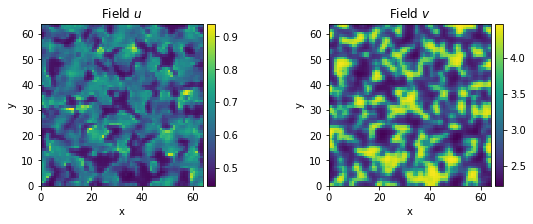

276
0.1 0.00505


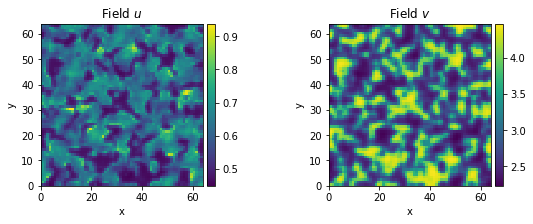

274
0.1 0.0001


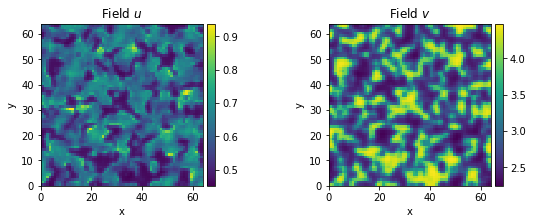

276
0.4 0.01


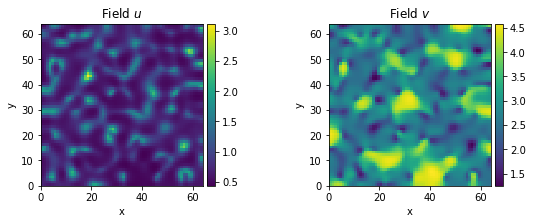

215
0.4 0.00505


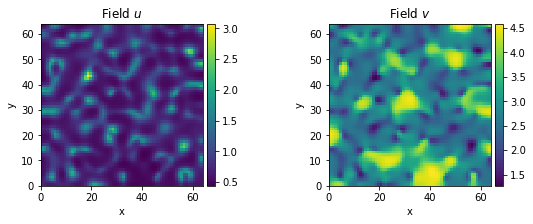

208
0.4 0.0001


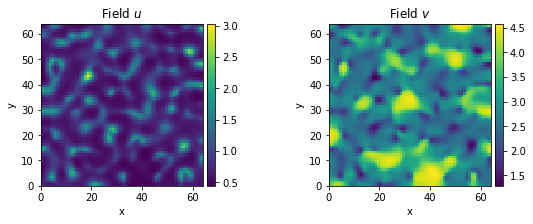

204
0.7 0.01


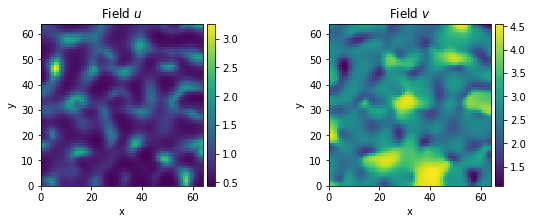

124
0.7 0.00505


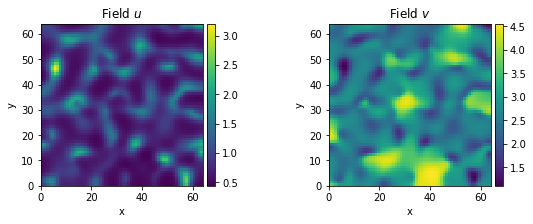

122
0.7 0.0001


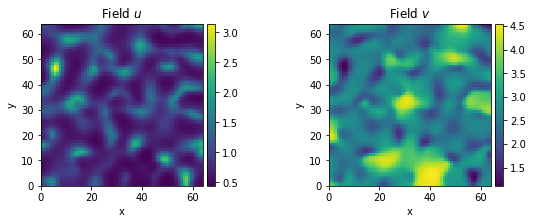

119
1.0 0.01


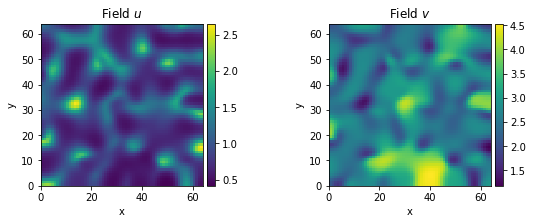

71
1.0 0.00505


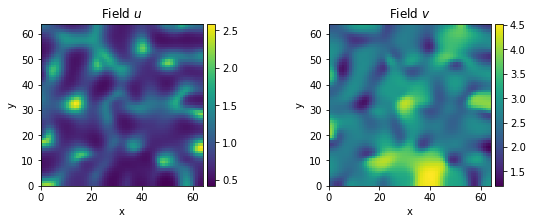

70
1.0 0.0001


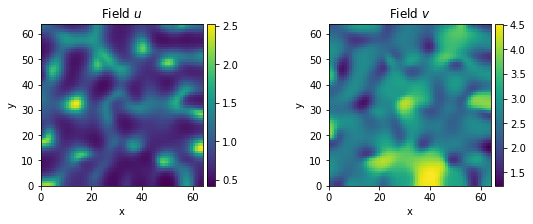

67


In [5]:
# Analyze results
#grid = UnitGrid([64, 64])  # generate grid
#state = ScalarField.random_uniform(grid, 0.2, 0.3)  # generate initial condition
f = lambda x: len(np.where(x > 4.25)[0])
result = {}
for diff in np.linspace(0.1,1,4):
    for dt in np.linspace(1e-2,1e-4,3):
        print(diff,dt)
        param["diffusivity"] = diff
        param["dt"] = dt
        sol,storage = run_PDE(param)
        sol.plot()
        print(f(sol.data[1,:,:].flatten()))
        f_name = "dt_"+str(dt)+"_diff_"+str(diff)
        result[f_name] = f(sol.data[0,:,:].flatten())
        #if dt == 1e-6:
        #    pde.visualization.movie(storage=storage,filename="./../assets/"+f_name+".mp4")



In [8]:
result

{'dt_0.01_diff_0.1': 204,
 'dt_0.00889_diff_0.1': 204,
 'dt_0.0077800000000000005_diff_0.1': 204,
 'dt_0.00667_diff_0.1': 204,
 'dt_0.00556_diff_0.1': 204,
 'dt_0.00445_diff_0.1': 204,
 'dt_0.0033399999999999992_diff_0.1': 204,
 'dt_0.0022299999999999993_diff_0.1': 204,
 'dt_0.0011199999999999995_diff_0.1': 204,
 'dt_1e-05_diff_0.1': 204,
 'dt_0.01_diff_0.2': 66,
 'dt_0.00889_diff_0.2': 66,
 'dt_0.0077800000000000005_diff_0.2': 66,
 'dt_0.00667_diff_0.2': 66,
 'dt_0.00556_diff_0.2': 66,
 'dt_0.00445_diff_0.2': 66,
 'dt_0.0033399999999999992_diff_0.2': 66,
 'dt_0.0022299999999999993_diff_0.2': 66,
 'dt_0.0011199999999999995_diff_0.2': 66,
 'dt_1e-05_diff_0.2': 66,
 'dt_0.01_diff_0.30000000000000004': 28,
 'dt_0.00889_diff_0.30000000000000004': 28,
 'dt_0.0077800000000000005_diff_0.30000000000000004': 28,
 'dt_0.00667_diff_0.30000000000000004': 28,
 'dt_0.00556_diff_0.30000000000000004': 28,
 'dt_0.00445_diff_0.30000000000000004': 28,
 'dt_0.0033399999999999992_diff_0.30000000000000004':

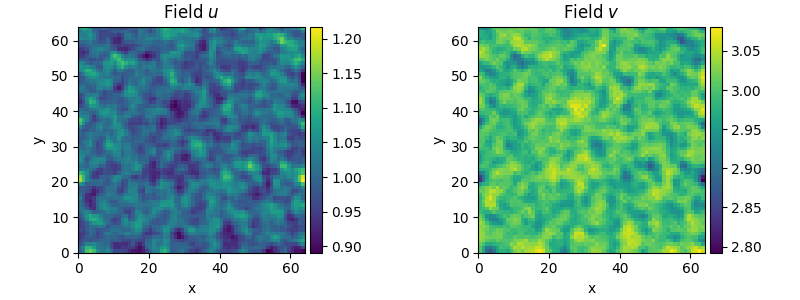

<ipython-input-8-f506b72a63fc>:20: RuntimeWarning: Mean of empty slice.
  average_time.append(np.array(t).mean())
/Users/pierthodo/anaconda3/envs/bayesopt/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


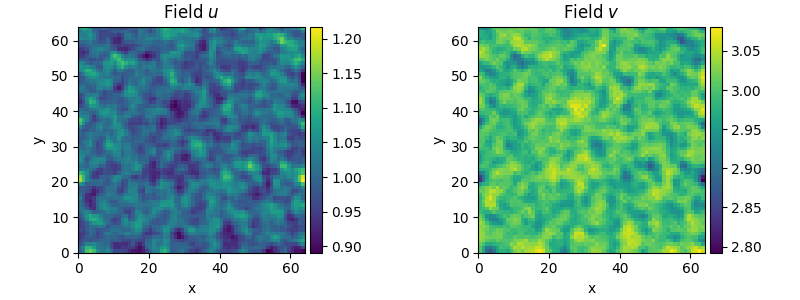

<ipython-input-8-f506b72a63fc>:20: RuntimeWarning: Mean of empty slice.
  average_time.append(np.array(t).mean())
/Users/pierthodo/anaconda3/envs/bayesopt/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


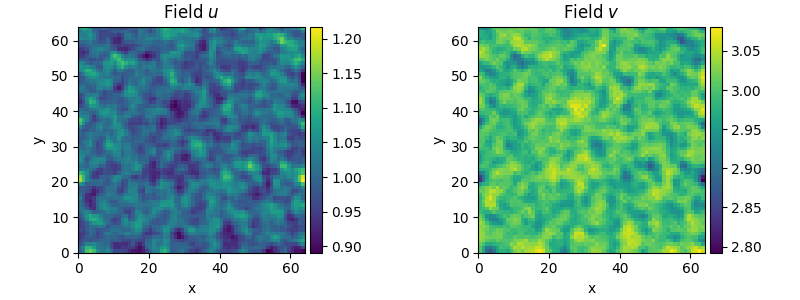

<ipython-input-8-f506b72a63fc>:20: RuntimeWarning: Mean of empty slice.
  average_time.append(np.array(t).mean())
/Users/pierthodo/anaconda3/envs/bayesopt/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


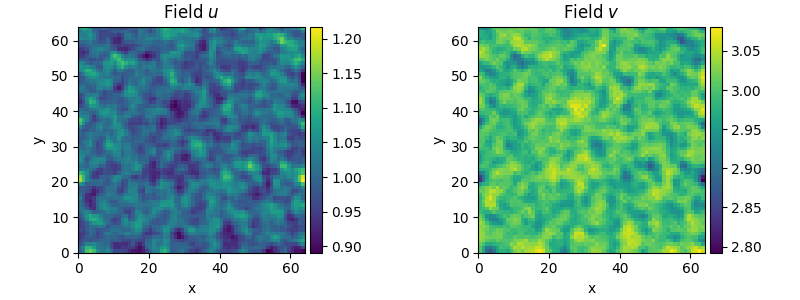

<ipython-input-8-f506b72a63fc>:20: RuntimeWarning: Mean of empty slice.
  average_time.append(np.array(t).mean())
/Users/pierthodo/anaconda3/envs/bayesopt/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


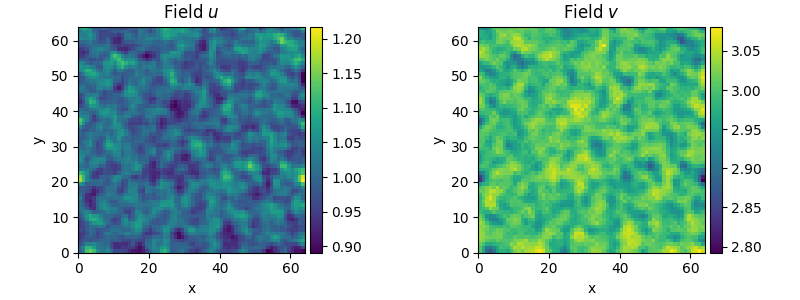

<ipython-input-8-f506b72a63fc>:20: RuntimeWarning: Mean of empty slice.
  average_time.append(np.array(t).mean())
/Users/pierthodo/anaconda3/envs/bayesopt/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


'\nnp.array(((sol_list[0] - i)**2).integrals).mean()\n\nerror_list  = [((sol_list[0] - i)**2).average for i in sol_list]\n\nfig, ax1 = plt.subplots()\nax1.set_yscale(\'log\')\nax2.set_yscale(\'log\')\n\nax2 = ax1.twinx()\nax1.plot(dt_list,average_time, \'g-\',label="Time")\nax2.plot(dt_list,error_list, \'b-\',label="Accuracy")\nfig.legend()\nsol_list[0].plot()\n'

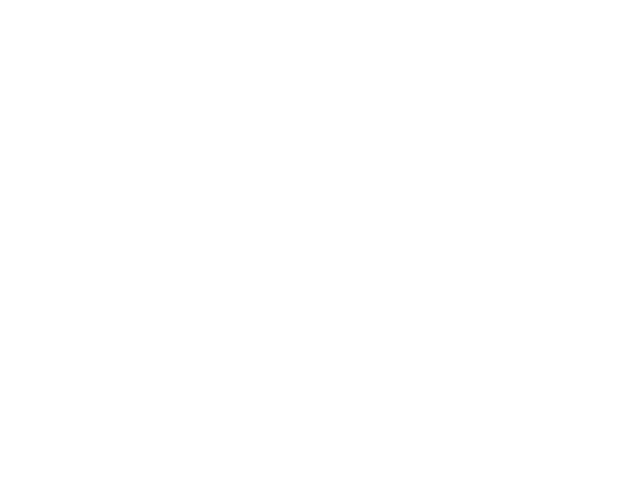

In [8]:
#def run(dt):
fig = plt.figure()
camera = Camera(fig)

#eq = pde.DiffusionPDE()
average_time = []
sol_list = []
solver1 = pde.ExplicitSolver(eq)



dt_list = np.linspace(1e-2,1e-4,5)
for dt in dt_list:
    t = []
    for rep in range(1):
        sol,storage = run_PDE(eq,state,1e-05)
        #t.append(float(controller1.diagnostics["controller"]["profiler"]["solver"]))
        sol.plot()
        camera.snap()
    average_time.append(np.array(t).mean())
    sol_list.append(sol)

animation = camera.animate()
#HTML(animation.to_html5_video())
np.array(((sol_list[0] - i)**2).integrals).mean()

error_list  = [((sol_list[0] - i)**2).average for i in sol_list]

fig, ax1 = plt.subplots()
ax1.set_yscale('log')
ax2.set_yscale('log')

ax2 = ax1.twinx()
ax1.plot(dt_list,average_time, 'g-',label="Time")
ax2.plot(dt_list,error_list, 'b-',label="Accuracy")
fig.legend()
sol_list[0].plot()


